In [1]:
# Import
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from math import sqrt

from sklearn.preprocessing import StandardScaler
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error

import sys
if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

# Data Cleaning and EDA

In [2]:
#load and read in the data
train_df = pd.read_csv('datasets/train.csv', index_col = "Id")
test_df = pd.read_csv('datasets/test.csv', index_col = "Id")
train_df.head()

,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,Utilities,...,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
109,533352170,60,RL,NaN,13517,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,3,2010,WD,130500
544,531379050,60,RL,43.0,11492,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,4,2009,WD,220000
153,535304180,20,RL,68.0,7922,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,1,2010,WD,109000
318,916386060,60,RL,73.0,9802,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,4,2010,WD,174000
255,906425045,50,RL,82.0,14235,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,3,2010,WD,138500


In [3]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2051 entries, 109 to 10
Data columns (total 80 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   PID              2051 non-null   int64  
 1   MS SubClass      2051 non-null   int64  
 2   MS Zoning        2051 non-null   object 
 3   Lot Frontage     1721 non-null   float64
 4   Lot Area         2051 non-null   int64  
 5   Street           2051 non-null   object 
 6   Alley            140 non-null    object 
 7   Lot Shape        2051 non-null   object 
 8   Land Contour     2051 non-null   object 
 9   Utilities        2051 non-null   object 
 10  Lot Config       2051 non-null   object 
 11  Land Slope       2051 non-null   object 
 12  Neighborhood     2051 non-null   object 
 13  Condition 1      2051 non-null   object 
 14  Condition 2      2051 non-null   object 
 15  Bldg Type        2051 non-null   object 
 16  House Style      2051 non-null   object 
 17  Overall Qual  

In [4]:
#Remove spaces and capitalization from column headers

def caps_spaces(df):
    column_headers = []
    for i in df.columns:
        i = i.lower()
        i = i.replace(' ', '_')
        column_headers.append(i)
    df.columns = column_headers

caps_spaces(train_df)
# caps_spaces(test_df)

In [5]:
# #describe the data
# train_df.describe()

# #check dtypes and nulls
# train_df.info()

In [6]:
#Print object and numeric columns for reference
object_cols = [i for i in train_df.dtypes.index if train_df.dtypes[i] == 'object']
print(f'Object Columns:\n {object_cols}\n\n')


numeric_cols = [i for i in train_df.dtypes.index if train_df.dtypes[i] != 'object']
print(f'Numeric Columns:\n {numeric_cols}')

Object Columns:
 ['ms_zoning', 'street', 'alley', 'lot_shape', 'land_contour', 'utilities', 'lot_config', 'land_slope', 'neighborhood', 'condition_1', 'condition_2', 'bldg_type', 'house_style', 'roof_style', 'roof_matl', 'exterior_1st', 'exterior_2nd', 'mas_vnr_type', 'exter_qual', 'exter_cond', 'foundation', 'bsmt_qual', 'bsmt_cond', 'bsmt_exposure', 'bsmtfin_type_1', 'bsmtfin_type_2', 'heating', 'heating_qc', 'central_air', 'electrical', 'kitchen_qual', 'functional', 'fireplace_qu', 'garage_type', 'garage_finish', 'garage_qual', 'garage_cond', 'paved_drive', 'pool_qc', 'fence', 'misc_feature', 'sale_type']


Numeric Columns:
 ['pid', 'ms_subclass', 'lot_frontage', 'lot_area', 'overall_qual', 'overall_cond', 'year_built', 'year_remod/add', 'mas_vnr_area', 'bsmtfin_sf_1', 'bsmtfin_sf_2', 'bsmt_unf_sf', 'total_bsmt_sf', '1st_flr_sf', '2nd_flr_sf', 'low_qual_fin_sf', 'gr_liv_area', 'bsmt_full_bath', 'bsmt_half_bath', 'full_bath', 'half_bath', 'bedroom_abvgr', 'kitchen_abvgr', 'totrms_abv

### Dummy the 'bldg_type' column

In [7]:
# bldg_type, exter_cond, central_air and kitchen_qual have 0 nulls
# Dummy them and add to the numeric_df for more percise modeling
train_df = pd.concat([train_df, pd.get_dummies(train_df['bldg_type'], drop_first=True)], axis=1)
object_cols = [i for i in train_df.dtypes.index if train_df.dtypes[i] == 'object']

In [8]:
train_df['2fmCon'] = train_df['2fmCon'].astype(int)
train_df['Duplex'] = train_df['Duplex'].astype(int)
train_df['Twnhs'] = train_df['Twnhs'].astype(int)
train_df['TwnhsE'] = train_df['TwnhsE'].astype(int)

### Convert 'qual' and 'cond' values from string ratings to numeric values

In [9]:
for i in train_df[object_cols].columns:
    if '_qual' in i or '_cond' in i:
        train_df[i] = train_df[i].map({'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5})
#         numeric_cols.append(i)

### Add new column to account for average  home value by neighborhood

In [10]:
# Crate a dictionary to house neighborhoods (keys) and their average home saleprice (values)
avg_prices_dict = {}
keys = train_df['neighborhood']
for i in keys:
    avg_prices_dict[i] = round(train_df[train_df['neighborhood'] == i]['saleprice'].mean(), 2)

In [11]:
train_df['avg_nhood_saleprice'] = train_df['neighborhood'].map(avg_prices_dict)
# train_df['avg_nhood_saleprice'] = train_df['neighborhood'].map(weeks)
train_df['avg_nhood_saleprice']

Id
109     137181.91
544     187760.16
153     145905.82
318     241051.35
255     187760.16
          ...    
1587    241051.35
785     130493.47
916     205901.21
639     145905.82
10      189228.39
Name: avg_nhood_saleprice, Length: 2051, dtype: float64

In [12]:
numeric_cols = [i for i in train_df.dtypes.index if train_df.dtypes[i] != 'object']

In [13]:
# For starters, identify the numeric columns that are missing values and those that are not
# Should we clean the ones that are missing? If it's not worth it or the null value counts are too high,
# we'll drop the column.
train_df[numeric_cols].isnull().sum()

pid                      0
ms_subclass              0
lot_frontage           330
lot_area                 0
overall_qual             0
overall_cond             0
year_built               0
year_remod/add           0
mas_vnr_area            22
exter_qual               0
exter_cond               0
bsmt_qual               55
bsmt_cond               55
bsmtfin_sf_1             1
bsmtfin_sf_2             1
bsmt_unf_sf              1
total_bsmt_sf            1
1st_flr_sf               0
2nd_flr_sf               0
low_qual_fin_sf          0
gr_liv_area              0
bsmt_full_bath           2
bsmt_half_bath           2
full_bath                0
half_bath                0
bedroom_abvgr            0
kitchen_abvgr            0
kitchen_qual             0
totrms_abvgrd            0
fireplaces               0
garage_yr_blt          114
garage_cars              1
garage_area              1
garage_qual            114
garage_cond            114
wood_deck_sf             0
open_porch_sf            0
e

### Drop numeric columns with too much missing data

In [14]:
train_df.drop(columns=['lot_frontage', 'mas_vnr_area', 'garage_yr_blt'], inplace=True)

In [15]:
numeric_cols = [i for i in train_df.dtypes.index if train_df.dtypes[i] != 'object']
# numeric_cols

### Impute mean value for single digit null values

In [16]:
#Impute missing numerical values with the mean
for i in train_df[numeric_cols].columns:
#     train_df[i].dropna(axis=0, inplace=True)
    if train_df[i].isnull().sum() != 0:
        train_df[i].fillna(train_df[i].mean(), inplace=True)

In [17]:
train_df[numeric_cols].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2051 entries, 109 to 10
Data columns (total 47 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   pid                  2051 non-null   int64  
 1   ms_subclass          2051 non-null   int64  
 2   lot_area             2051 non-null   int64  
 3   overall_qual         2051 non-null   int64  
 4   overall_cond         2051 non-null   int64  
 5   year_built           2051 non-null   int64  
 6   year_remod/add       2051 non-null   int64  
 7   exter_qual           2051 non-null   int64  
 8   exter_cond           2051 non-null   int64  
 9   bsmt_qual            2051 non-null   float64
 10  bsmt_cond            2051 non-null   float64
 11  bsmtfin_sf_1         2051 non-null   float64
 12  bsmtfin_sf_2         2051 non-null   float64
 13  bsmt_unf_sf          2051 non-null   float64
 14  total_bsmt_sf        2051 non-null   float64
 15  1st_flr_sf           2051 non-null   i

In [18]:
features_df = train_df[numeric_cols]
features_df.dropna(inplace=True)

# Initial Modeling and Evaluation

In [19]:
# numeric_df['overall_qual'] = numeric_df['overall_qual'].map(np.log)#Transform the best feature

In [20]:
# y_train_log = y_train.map(np.log)
# y_test_log = y_test.map(np.log)

### Linear Regression

In [21]:
#Define features
# features = [col for col in numeric_df.columns if col != 'saleprice']
X = features_df[[col for col in features_df.columns if col != 'saleprice']]
y = features_df['saleprice']

In [22]:
#Test train split 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.8)

In [23]:
# fit standard scaler
ss = StandardScaler()
ss.fit(X_train)

X_train_ss = ss.transform(X_train)
X_test_ss = ss.transform(X_test)

In [24]:
# instantiate the estimator
lr = LinearRegression(n_jobs = -1)

#fit the estimater
model = lr.fit(X_train_ss, y_train)

# perform 5-fold cross validation
scores = cross_val_score(model, X_train_ss, y_train)

# lr_cross_vals = scores
# lr_r2_train = model.score(X_train_ss, y_train)
# lr_r2_test = model.score(X_test_ss, y_train)
print(f'Cross-val scores: {scores}')
print(f'Mean with confidence inteveral: {round(scores.mean(), 3)} +- {round(2 * scores.std(), 2)} \n')
print(f'R^2 train score: {model.score(X_train_ss, y_train)}')
print(f'R^2 test score: {model.score(X_test_ss, y_test)}')

Cross-val scores: [ 8.70079648e-01  8.70230700e-01  8.45115411e-01  8.36635946e-01
 -2.30814124e+09]
Mean with confidence inteveral: -461628246.401 +- 1846512989.03 

R^2 train score: 0.9037447705019697
R^2 test score: 0.8302302335043192


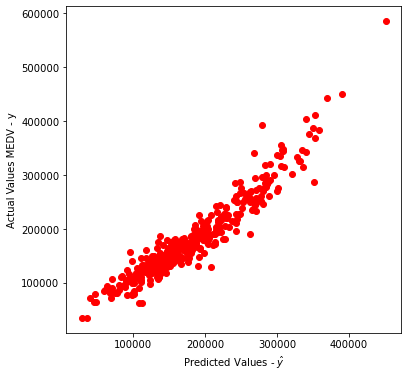

In [25]:
#plot residuals
predictions = model.predict(X_train_ss)

# Plot the model
plt.figure(figsize=(6,6))
plt.scatter(predictions, y_train, c ='r')
plt.xlabel("Predicted Values - $\hat{y}$")
plt.ylabel("Actual Values MEDV - y")
plt.show()

### Ridge

In [26]:
#create ridge
ridge = RidgeCV()

#fit the estimater
model = ridge.fit(X_train_ss, y_train)

# perform 5-fold cross validation
scores = cross_val_score(model, X_train_ss, y_train)

print('Cross-val scores:', scores)
print(f'Mean with confidence inteveral: {round(scores.mean(), 3)} +- {round(2 * scores.std(), 2)} \n')
print(f'R^2 train score: {ridge.score(X_train_ss, y_train)}')
print(f'R^2 test score: {ridge.score(X_test_ss, y_test)}')

Cross-val scores: [0.87664802 0.8711243  0.84430134 0.85217935 0.88313173]
Mean with confidence inteveral: 0.865 +- 0.03 

R^2 train score: 0.9035352296100841
R^2 test score: 0.8325587015939515


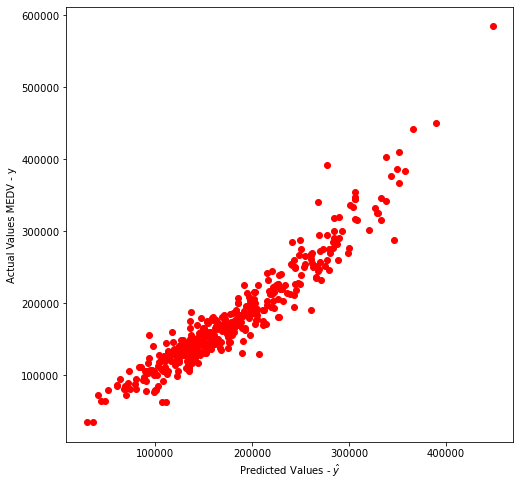

In [27]:
#plot residuals
predictions = model.predict(X_train_ss)

# Plot the model
plt.figure(figsize=(8,8))
plt.scatter(predictions, y_train, c ='r')
plt.xlabel("Predicted Values - $\hat{y}$")
plt.ylabel("Actual Values MEDV - y")
plt.show()

In [28]:
# Which alpha is best?

from sklearn.linear_model import LassoCV


# fit LassoCV
lasso_cv = LassoCV(cv = 10).fit(X_train_ss, y_train)

print('best alpha:', lasso_cv.alpha_)
print('score:', lasso_cv.score(X, y))

best alpha: 726.1829059671343
score: -1443529405.9822922


### Lasso

In [29]:
lasso = LassoCV()
model = lasso.fit(X_train_ss, y_train)

scores = cross_val_score(model, X_train_ss, y_train)

print('Cross-val scores:', scores)
print(f'Mean with confidence inteveral: {round(scores.mean(), 3)} +- {round(2 * scores.std(), 2)} \n')
print(f'R^2 train score: {ridge.score(X_train_ss, y_train)}')
print(f'R^2 test score: {ridge.score(X_test_ss, y_test)}')

Cross-val scores: [0.87759444 0.88234427 0.83595014 0.86544663 0.88481472]
Mean with confidence inteveral: 0.869 +- 0.04 

R^2 train score: 0.9035352296100841
R^2 test score: 0.8325587015939515


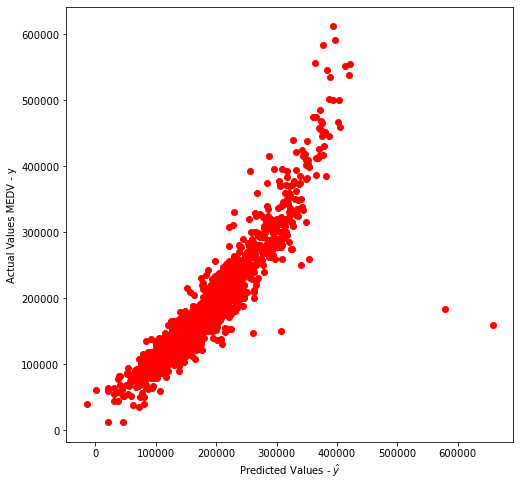

In [30]:
#plot residuals
predictions = model.predict(X_test_ss)

# Plot the model
plt.figure(figsize=(8,8))
plt.scatter(predictions, y_test, c ='r')
plt.xlabel("Predicted Values - $\hat{y}$")
plt.ylabel("Actual Values MEDV - y")
plt.show()

# Insights / Further EDA
### Based on the fact that the test scores are consistantly MUCH lower than the train, we can infer that the model is overfit.
- Lets look at correlation values and reduce features accordingly
- We'll also remove colinear features where possible.

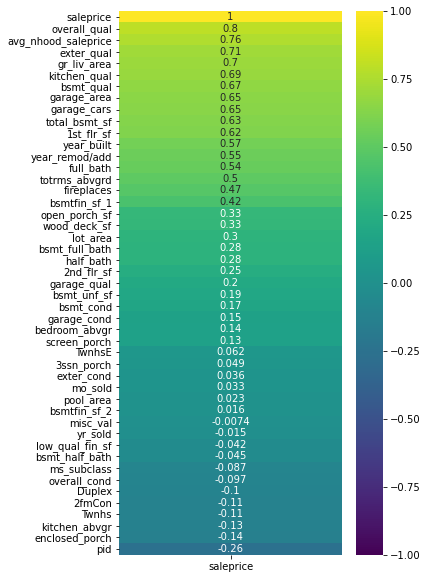

In [31]:
#Heatmap
plt.figure(figsize=(5,10))
sns.heatmap(features_df.corr()[['saleprice']].sort_values('saleprice', ascending=False),
           annot=True,
           cmap='viridis',
           vmin=-1,
           vmax=1);
plt.savefig('heatmap')

In [32]:
# function to produce scores based on correlation to saleprice

def corr_to_score(corr):
    saleprice_corrs = features_df.corr()[['saleprice']].sort_values('saleprice', ascending=False)
    finer_features = saleprice_corrs['saleprice'][saleprice_corrs['saleprice'] > corr].index
    
    X_new = features_df[[col for col in finer_features if col != 'saleprice']]
    y = features_df['saleprice']
    X_train_new, X_test_new, y_train, y_test = train_test_split(X_new, y, random_state=42)
    
    # fit the scaler
    ss = StandardScaler()
    ss.fit(X_train_new)
    X_train_new_ss = ss.transform(X_train_new)
    X_test_new_ss = ss.transform(X_test_new)

    #linear regression
    # instantiate the estimator
    lr = LinearRegression(n_jobs = -1)
    #fit the estimater
    model = lr.fit(X_train_new_ss, y_train)
    # perform 5-fold cross validation
    scores = cross_val_score(model, X_train_new_ss, y_train)
    print(f'Linear Regression Cross-val scores: {scores}')
    print(f'Mean with confidence inteveral: {round(scores.mean(), 3)} +- {round(2 * scores.std(), 2)}')
    print(f'Linear Regression R^2 train score: {model.score(X_train_new_ss, y_train)}')
    print(f'Linear Regression R^2 test score: {model.score(X_test_new_ss, y_test)} \n \n')
    
    # Ridge
    ridge = RidgeCV()
    # fit the estimater
    model = ridge.fit(X_train_new_ss, y_train)
    # perform 5-fold cross validation
    scores = cross_val_score(model, X_train_new_ss, y_train)
    print('Ridge Cross-val scores:', scores)
    print(f'Mean with confidence inteveral: {round(scores.mean(), 3)} +- {round(2 * scores.std(), 2)}')
    print(f'Ridge R^2 train score: {ridge.score(X_train_new_ss, y_train)}')
    print(f'Ridge R^2 test score: {ridge.score(X_test_new_ss, y_test)} \n \n')
    
    # Lasso
    lasso = LassoCV()
    # fit the estimater
    model = lasso.fit(X_train_new_ss, y_train)
    # perform 5-fold cross validation
    scores = cross_val_score(model, X_train_new_ss, y_train)
    print('Lasso Cross-val scores:', scores)
    print(f'Mean with confidence inteveral: {round(scores.mean(), 3)} +- {round(2 * scores.std(), 2)}')
    print(f'Lasso R^2 train score: {model.score(X_train_new_ss, y_train)}')
    print(f'Lasso R^2 test score: {model.score(X_test_new_ss, y_test)}')

In [33]:
#After playing around a bit we can see that filtering for features that have at least a .43 correlation rate
#with sale price gives us the highest scores and low confidence intervals
corr_to_score(.2)

Linear Regression Cross-val scores: [0.86124659 0.83179511 0.85906912 0.8197529  0.66548173]
Mean with confidence inteveral: 0.807 +- 0.15
Linear Regression R^2 train score: 0.8388899670894272
Linear Regression R^2 test score: 0.8717437539401691 
 

Ridge Cross-val scores: [0.86141105 0.83293867 0.86076841 0.81958879 0.66763012]
Mean with confidence inteveral: 0.808 +- 0.14
Ridge R^2 train score: 0.838881702808983
Ridge R^2 test score: 0.872017936839409 
 

Lasso Cross-val scores: [0.85832343 0.83515212 0.849608   0.81819365 0.67555608]
Mean with confidence inteveral: 0.807 +- 0.13
Lasso R^2 train score: 0.8383230751455485
Lasso R^2 test score: 0.8721236227692029


In [34]:
saleprice_corrs = features_df.corr()[['saleprice']].sort_values('saleprice', ascending=False)
finer_features = saleprice_corrs['saleprice'][saleprice_corrs['saleprice'] > .43].index

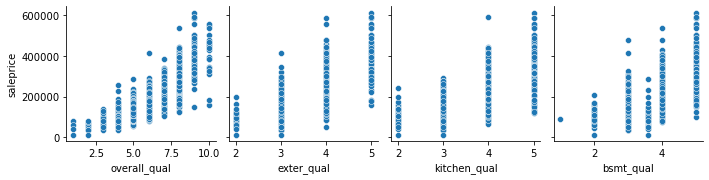

In [35]:
# Correlation scatter plots
# Lets examine the high performing 'quality' based features.
# These were manually converted to numeric values earlier
sns.pairplot(features_df, x_vars=[f for f in finer_features if '_qual' in f], y_vars=['saleprice'])
plt.savefig('quals')

Text(0.5, 1.0, 'Basement Quality Score Distro')

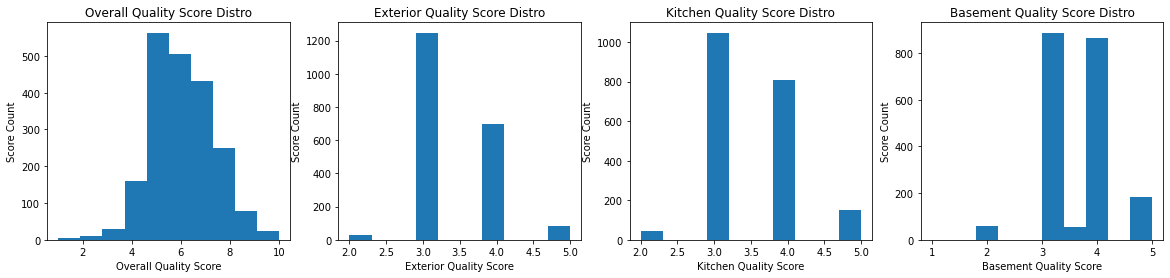

In [36]:
# rows x columns
fig, ax = plt.subplots(1, 4, figsize = (20, 4))

#fig1: overall_qual
ax[0].hist(features_df['overall_qual']);
ax[0].set_xlabel('Overall Quality Score')
ax[0].set_ylabel('Score Count')
ax[0].set_title('Overall Quality Score Distro')

#fig2: exter_qual
ax[1].hist(features_df['exter_qual']);
ax[1].set_xlabel('Exterior Quality Score')
ax[1].set_ylabel('Score Count')
ax[1].set_title('Exterior Quality Score Distro')

#fig3: kitchen_qual
ax[2].hist(features_df['kitchen_qual']);
ax[2].set_xlabel('Kitchen Quality Score')
ax[2].set_ylabel('Score Count')
ax[2].set_title('Kitchen Quality Score Distro')

#fig1: bsmt_qual
ax[3].hist(features_df['bsmt_qual']);
ax[3].set_xlabel('Basement Quality Score')
ax[3].set_ylabel('Score Count')
ax[3].set_title('Basement Quality Score Distro')

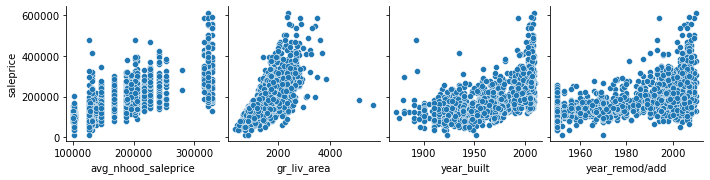

In [37]:
# Lets examine other high performing features.
sns.pairplot(features_df, x_vars=features_df[['avg_nhood_saleprice', 'gr_liv_area', 'year_built', 'year_remod/add']], y_vars=['saleprice'])

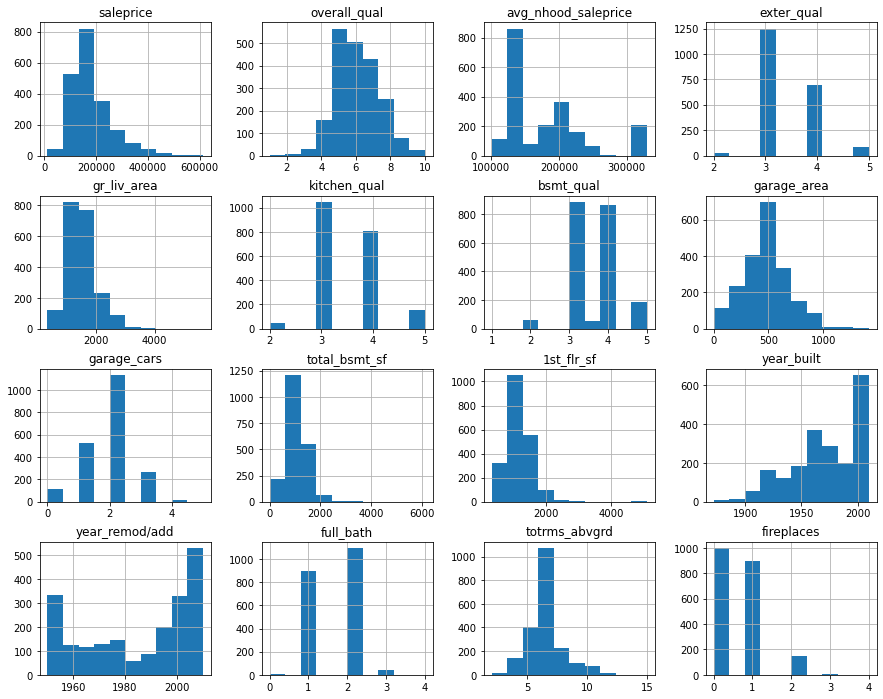

In [38]:
# Histogram feature distrobutions 
features_df[finer_features].hist(figsize=(15,12));

<AxesSubplot:xlabel='saleprice'>

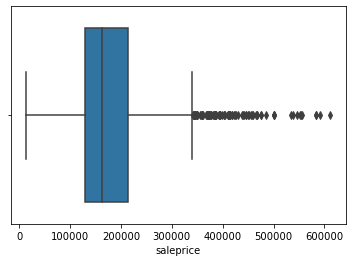

In [39]:
#Boxplot
sns.boxplot(x=features_df['saleprice'])

<AxesSubplot:xlabel='saleprice'>

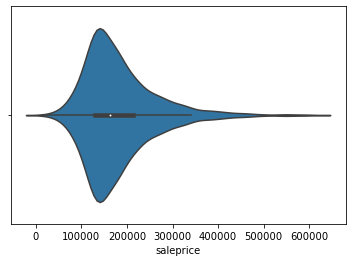

In [40]:
#Violinplot
sns.violinplot(x=features_df['saleprice'])

#### Identifying multicollinearity
- The pandas 'corrs_df' below identifies all features that have a correlation above .7
- This will allow us to note instnaces where including both features in the model is unnecessary.
- Values to drop:
    - ...

In [41]:
corrs_stack = features_df.corr().stack() > .6
corrs_df = pd.DataFrame(data=corrs_stack)
corrs_df = corrs_df[corrs_df[0]].reset_index().rename(columns={"level_0": "f1", "level_1": "f2", 0: "value"})
corrs_df[corrs_df["f1"].duplicated(keep=False)].to_csv('corrs_df.csv')
corrs_df

,f1,f2,value
0,pid,pid,True
1,ms_subclass,ms_subclass,True
2,lot_area,lot_area,True
3,overall_qual,overall_qual,True
4,overall_qual,year_built,True
...,...,...,...
112,avg_nhood_saleprice,exter_qual,True
113,avg_nhood_saleprice,bsmt_qual,True
114,avg_nhood_saleprice,kitchen_qual,True
115,avg_nhood_saleprice,saleprice,True


In [42]:
[f for f in features_df.columns if 'qual'in f]

['overall_qual',
 'exter_qual',
 'bsmt_qual',
 'low_qual_fin_sf',
 'kitchen_qual',
 'garage_qual']

In [43]:
# Now we'll check the residuals. The goal is to get residuals as close to the irreducable errors as possible.
# Since irreducable error has a mean of 0 and is normally distributed, plotting the residuals with a histogram
# will revela whether they mimic that ideal shape 

# residuals = y - predictions
# plt.hist(residuals, bins=30);

# Test new improved model features

In [44]:
#Re-define features
# features = [col for col in numeric_df.columns if col != 'saleprice']
X_new = features_df[[col for col in finer_features if col != 'saleprice']]
y = features_df['saleprice']

In [45]:
# Test train split 
X_train_new, X_test_new, y_train, y_test = train_test_split(X_new, y)

In [46]:
# fit standard scaler
ss = StandardScaler()
ss.fit(X_train_new)

X_train_new_ss = ss.transform(X_train_new)
X_test_new_ss = ss.transform(X_test_new)

In [47]:
# instantiate the estimator
lr = LinearRegression(n_jobs = -1)

#fit the estimater
model = lr.fit(X_train_new_ss, y_train)

# perform 5-fold cross validation
scores = cross_val_score(model, X_train_new_ss, y_train)

print(f'Cross-val scores: {scores}')
print(f'Mean with confidence inteveral: {round(scores.mean(), 3)} +- {round(2 * scores.std(), 2)} \n')
print(f'R^2 train score: {model.score(X_train_new_ss, y_train)}')
print(f'R^2 test score: {model.score(X_test_new_ss, y_test)}')

Cross-val scores: [0.72915984 0.83334735 0.86974949 0.85868039 0.84352574]
Mean with confidence inteveral: 0.827 +- 0.1 

R^2 train score: 0.8379600129826807
R^2 test score: 0.8313077855113538


In [48]:
#Ridge
#fit the estimater
model = ridge.fit(X_train_new_ss, y_train)

# perform 5-fold cross validation
scores = cross_val_score(model, X_train_new_ss, y_train)

print('Cross-val scores:', scores)
print(f'Mean with confidence inteveral: {round(scores.mean(), 3)} +- {round(2 * scores.std(), 2)} \n')
print(f'R^2 train score: {model.score(X_train_new_ss, y_train)}')
print(f'R^2 test score: {model.score(X_test_new_ss, y_test)}')

Cross-val scores: [0.7325205  0.83365552 0.86976987 0.85834031 0.84351945]
Mean with confidence inteveral: 0.828 +- 0.1 

R^2 train score: 0.8379506694764316
R^2 test score: 0.8311248179564498


In [49]:
# Lasso
model = lasso.fit(X_train_new_ss, y_train)

scores = cross_val_score(model, X_train_new_ss, y_train)

print('Cross-val scores:', scores)
print(f'Mean with confidence inteveral: {round(scores.mean(), 3)} +- {round(2 * scores.std(), 2)} \n')
print(f'R^2 train score: {model.score(X_train_new_ss, y_train)}')
print(f'R^2 test score: {model.score(X_test_new_ss, y_test)}')

Cross-val scores: [0.74036934 0.8300255  0.86723255 0.85587528 0.84025753]
Mean with confidence inteveral: 0.827 +- 0.09 

R^2 train score: 0.8352118085668234
R^2 test score: 0.8318455860816432


## Conclusions and Next Steps 

- Inital data preprocessing (which included dummy columns) gave us a model that was massively overfit
- Reducing model features to only those with moderate - high correlation rates with 'saleprice' improved scores and reduced the differnece in performance between the 3 models we tested.
    - While the he consistancy reassures us that the data cleaning, preprocessing and scaling is effective, we also dont want to over dilute our model. 
    
- Based on our final results here, the Lasso model gives us results consistant with the other two models but with a tighter confidence interval as well.

#### Future considerations

- Further feature engineering. Identifying oppurtunities to feature engineer without just relying on one-hot encoding which led to extremee over fitting.
- Removing multicolinear features. Many of the columns (which had high corrolation rates to saleprice) were redundant (for example:  bsmt_qual', 'bsmt_cond', bsmtfin_sf_1', 'bsmtfin_sf_2', 'bsmt_unf_sf, etc.) All of these could liekly be encompased by one or two variables. Simplifying model features like these across the board + in addition to feature engineering could produce a higher performing model.